# OpenCV 기반 YOLO-Version3로 Object Detection 수행
- OpenCV는 CPU만 제공하기 때문에 CPU만을 사용해서 탐지 속도가 느린 경향 존재

In [1]:
!pwd
!rm -rf DLCV
!git clone https://github.com/chulminkw/DLCV.git

/content
Cloning into 'DLCV'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (71/71), done.
Receiving objects: 100% (234/234), 142.72 MiB | 39.45 MiB/s, done.
remote: Total 234 (delta 32), reused 0 (delta 0), pack-reused 159
Resolving deltas: 100% (89/89), done.


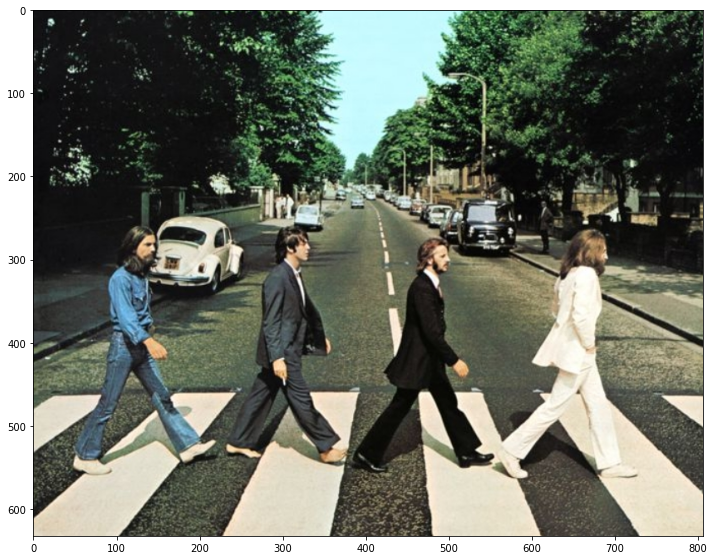

In [2]:
# 탐지할 이미지 로드
import cv2
import matplotlib.pyplot as plt
import os
%matplotlib inline

default_dir = '/content/DLCV'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

In [3]:
# Pretrained 모델인 YOLO와 Tiny YOLO 모델 wget 명령어로 다운로드
# YOLO 경우 다운로드 시 약 18분 소요.. Tiny는 약 4분 소요 => 코랩은 엄청 빨리됨
!rm -rf /content/DLCV/Detection/yolo//pretrained
!mkdir /content/DLCV/Detection/yolo/pretrained
# pretrained 디렉토리가 생성되었는지 확인 합니다. 
%cd /content/DLCV/Detection/yolo
!ls

### coco 데이터 세트로 pretrained 된 yolo weight 파일과 config 파일 다운로드 
%cd /content/DLCV/Detection/yolo/pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg

!wget https://pjreddie.com/media/files/yolov3-tiny.weights
!wget wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg

!echo "##### check out pretrained yolo files"
!ls /content/DLCV/Detection/yolo/pretrained

/content/DLCV/Detection/yolo
KerasYolo_이미지와_영상_Detection.ipynb
KerasYolo_OpenImage_학습및_Detection.ipynb
KerasYolo_Raccoon_학습및_Detection.ipynb
OpenCV_Yolo_이미지와_영상_Detection.ipynb
pretrained
/content/DLCV/Detection/yolo/pretrained
##### downloading pretrained yolo/tiny-yolo weight file and config file
--2021-04-15 05:57:48--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights’

yolov3.weights      100%[===================>] 236.52M  44.8MB/s    in 5.6s    

2021-04-15 05:57:54 (42.0 MB/s) - ‘yolov3.weights’ saved [248007048/248007048]

--2021-04-15 05:57:54--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... co

## YOLO 모델 사용 시 코드 작성 주의할 점
- ``readNetFromDarknet(config, weight)``로 인자 순서 사용
- 사용자가 3개의 서로 다른 Feature Map의 Output layer에서 Object Detection 결과 추출해야 함
- 사용자가 직점 NMS 필터링해주어야 함
  * Confidence threshold, NMS threshold 하이퍼라리미터로 지정해주어야 함
  * ``cv2.dnn.NMSBoxes(탐지한 박스들, 탐지한 object confidence, confidence_threshold, nms_threshold)`` 메소드사용

In [4]:
import os

CUR_DIR = '/content/DLCV/Detection/yolo'
weights_path = os.path.join(CUR_DIR, 'pretrained/yolov3.weights')
config_path = os.path.join(CUR_DIR, 'pretrained/yolov3.cfg')

# YOLO 모델 로드
cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

In [5]:
# YOLO 모델 COCO 데이터셋 class_id-name 매핑은 0~79까지임
labels_to_names_seq = {0:'person',1:'bicycle',2:'car',3:'motorbike',4:'aeroplane',5:'bus',6:'train',7:'truck',8:'boat',9:'traffic light',10:'fire hydrant',
                        11:'stop sign',12:'parking meter',13:'bench',14:'bird',15:'cat',16:'dog',17:'horse',18:'sheep',19:'cow',20:'elephant',
                        21:'bear',22:'zebra',23:'giraffe',24:'backpack',25:'umbrella',26:'handbag',27:'tie',28:'suitcase',29:'frisbee',30:'skis',
                        31:'snowboard',32:'sports ball',33:'kite',34:'baseball bat',35:'baseball glove',36:'skateboard',37:'surfboard',38:'tennis racket',39:'bottle',40:'wine glass',
                        41:'cup',42:'fork',43:'knife',44:'spoon',45:'bowl',46:'banana',47:'apple',48:'sandwich',49:'orange',50:'broccoli',
                        51:'carrot',52:'hot dog',53:'pizza',54:'donut',55:'cake',56:'chair',57:'sofa',58:'pottedplant',59:'bed',60:'diningtable',
                        61:'toilet',62:'tvmonitor',63:'laptop',64:'mouse',65:'remote',66:'keyboard',67:'cell phone',68:'microwave',69:'oven',70:'toaster',
                        71:'sink',72:'refrigerator',73:'book',74:'clock',75:'vase',76:'scissors',77:'teddy bear',78:'hair drier',79:'toothbrush' }

In [9]:
# YOLO에서 3개의 서로 다른 크기의 Feature Map Output layer에서 결과 데이터 추출
layer_names = cv_net_yolo.getLayerNames() # YOLO 모델에서 모든 Layer 이름을 얻기
print('모든 레이어들:', layer_names)
# getUnconnectedOutLayers(): YOLO-V3 모델에서 서로 다른 Feature Map의 아웃풋 layer가 몇 번째 layer인지
print('Output layer들이 몇 번째 인지:', cv_net_yolo.getUnconnectedOutLayers())
# 각 Output layer에서 1을 뺀 숫자 위치 값이 layer_names 리스트에서 올바른 위치임!
outlayer_names = [layer_names[i[0] - 1] for i in cv_net_yolo.getUnconnectedOutLayers()]
print('Output layer names:', outlayer_names)

모든 레이어들: ['conv_0', 'bn_0', 'relu_0', 'conv_1', 'bn_1', 'relu_1', 'conv_2', 'bn_2', 'relu_2', 'conv_3', 'bn_3', 'relu_3', 'shortcut_4', 'conv_5', 'bn_5', 'relu_5', 'conv_6', 'bn_6', 'relu_6', 'conv_7', 'bn_7', 'relu_7', 'shortcut_8', 'conv_9', 'bn_9', 'relu_9', 'conv_10', 'bn_10', 'relu_10', 'shortcut_11', 'conv_12', 'bn_12', 'relu_12', 'conv_13', 'bn_13', 'relu_13', 'conv_14', 'bn_14', 'relu_14', 'shortcut_15', 'conv_16', 'bn_16', 'relu_16', 'conv_17', 'bn_17', 'relu_17', 'shortcut_18', 'conv_19', 'bn_19', 'relu_19', 'conv_20', 'bn_20', 'relu_20', 'shortcut_21', 'conv_22', 'bn_22', 'relu_22', 'conv_23', 'bn_23', 'relu_23', 'shortcut_24', 'conv_25', 'bn_25', 'relu_25', 'conv_26', 'bn_26', 'relu_26', 'shortcut_27', 'conv_28', 'bn_28', 'relu_28', 'conv_29', 'bn_29', 'relu_29', 'shortcut_30', 'conv_31', 'bn_31', 'relu_31', 'conv_32', 'bn_32', 'relu_32', 'shortcut_33', 'conv_34', 'bn_34', 'relu_34', 'conv_35', 'bn_35', 'relu_35', 'shortcut_36', 'conv_37', 'bn_37', 'relu_37', 'conv_38', 'bn

In [12]:
# 로드한 YOLO 모델에 OpenCV를 이용해서 입력 이미지 넣기!
cv_net_yolo.setInput(cv2.dnn.blobFromImage(img, scalefactor=1/255.0,
                                           size=(416, 416), swapRB=True,
                                           crop=False))
# 입력시킨 이미지를 YOLO로 Object Detection 수행!
cv_outs = cv_net_yolo.forward(outlayer_names) # Outlayer 인자로 주어서 각 Feature Map Output 마다 Object Detection 수행 후 결합한 결과 도출, 하나의 리스트로 반환됨

green_color = (0, 255, 0)
red_color = (0, 0, 255)

In [71]:
# cv_outs의 0번 인덱스에는 하나의 Feature Map에 대한 Object Detection 결과가 담겨있음.. 1번인덱스.. 2번인덱스..도 동일(Output layer가 3개니까 2번 인덱스까지 밖에 없음)

import numpy as np

# 모델 입력시 (416, 416)으로 resize했지만 YOLO를 거치고 난 다음 다시 스케일된 사이즈로 나오므로 다시 (416, 416)으로 resize 해주어야 함!
height = img.shape[0]
width = img.shape[1]

conf_threshold = 0.5
nms_threshold = 0.4

class_ids = []
boxes = []
confidences = []

# 3개의 Ouput에 대해 하나씩 loop
for idx, output in enumerate(cv_outs):
  print('output shape:', output.shape) # (507, 85) (2028, 85) (8112, 85)로 3개가 나옴
  # 하나의 Output에 대해서 나온 Object Detection 정보들 -> (507, 85)에서 (1, 85) ~ (507, 85) 처리
  for idx2, detection in enumerate(output):
    # 80개의 클래스에 대한 score들은 5번째 index부터 있음
    scores = detection[5:]
    # scores 배열에서 가장 높은 값(confidence score)을 갖는 index가 class_id임!
    class_id = np.argmax(scores)
    # socres 배열에서 그 class_id에 있는 값이 가장 높은 confidence score
    confidence = scores[class_id]

    # 특정 cofidence score보다 높은 즉, 어떤 물체일 확률이 높은 것들만!
    if confidence > conf_threshold:
      #print('idx:', idx, 'idx2:', idx2, 'class_id:', class_id, 'confidence:', confidence)
      # detection의 0~3번째 인덱스는 예측된 박스의 중심 좌표(x,y)와 width, height가 들어 있음
      # 이에 대한 resize된 좌표를 계산
      center_x = int(detection[0] * width)
      center_y = int(detection[1] * height)
      o_width = int(detection[2] * width)
      o_height = int(detection[3] * height)
      # 좌상단 좌표 구하기
      left = int(center_x - o_width/2)
      top = int(center_y - o_height/2) # y좌표는 아래로 갈수록 커지는 것임!!! 그래서 -임!
      # 각 Feature Map Output layer별로 디텍트된 정보 데이터 담기
      class_ids.append(class_id)
      confidences.append(float(confidence)) # confidence값의 type이 np.float 타입이 아닌 just float 타입이어야 함! 그러므로 float()으로 감싸주기!
      boxes.append([left, top, o_width, o_height])

output shape: (507, 85)
output shape: (2028, 85)
output shape: (8112, 85)


- Confidence type must be float not np.float.<a href='https://github.com/opencv/opencv/issues/12789'>Github issue</a>

In [55]:
# 여러가지 바운딩 박스 후보들이 나온상태에서 NMS 필터링을 사용해 최적의 박스들만 남기기
conf_threshold = 0.5
nms_threshold = 0.4

# 박스 좌표들, 박스별 confidence score들, cofidence임곗값, nms 임곗값 인자로 주기
'''
Boxes = [[x1, y1, w1, h1], [x2, y2, w2, h2], [x3, y3, w3, h3], ...]
score = [[score1],         [score2],         [score3],         ...]
'''
# NMS를 거치고 난 후의 최적의 박스들만 남기고 그 박스들이 위치한 위 리스트의 index를 반환
optimal_idx = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
print(optimal_idx, type(optimal_idx))

[[ 2]
 [ 7]
 [ 3]
 [ 6]
 [14]
 [12]
 [10]
 [15]
 [ 5]
 [ 4]
 [17]
 [16]
 [11]
 [13]] <class 'numpy.ndarray'>


- ``flatten()`` vs ``ravel()``
  - ``flatten()``
    - 항상 배열의 복사본을 반환
  - ``ravel()``
    - 이게 더 빠름
    - 반환 한 배열을 수정하면 원본 배열이 수정될 수 있음..!
    - 그러므로 원본 배열을 더이상 사용하지 않을 때 사용하자

person: 0.9984
person: 0.9984
person: 0.9978
person: 0.9878
car: 0.9504
car: 0.9412
car: 0.9077
car: 0.9064
car: 0.8473
car: 0.8170
person: 0.7641
car: 0.6900
car: 0.6332
car: 0.6154


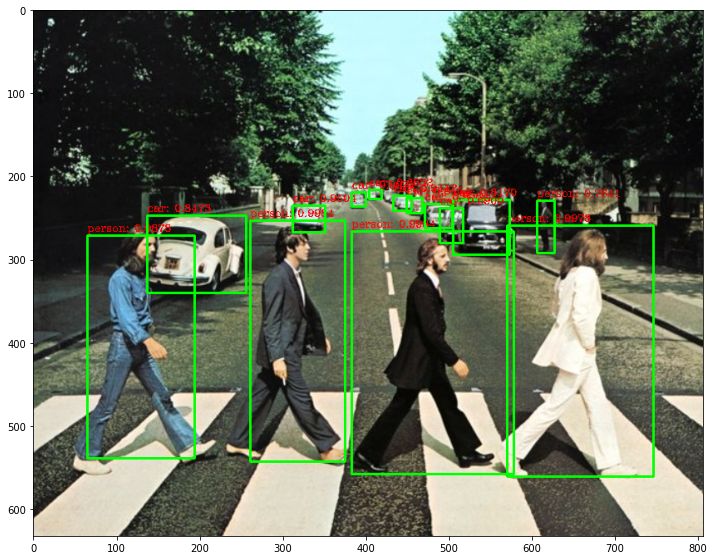

In [56]:
# NMS로 필터링된 최적의 바운딩 박스들의 좌표, 클래스 이름, score 이미지에 그리기
draw_img = img.copy()

if len(optimal_idx) > 0: # 만약 최적의 바운딩 박스가 1개라도 있다면 표시해!
  for i in optimal_idx.flatten():
    # 해당 박스의 좌표들
    box = boxes[i] 
    left = box[0]
    top = box[1]
    width = box[2]
    height = box[3]
    # right = int(left + box[2])
    # bottom = int(top - box[3])
    caption = "{}: {:.4f}".format(labels_to_names_seq[class_ids[i]], confidences[i])
    
    # 이미지에 새기기
    cv2.rectangle(draw_img, (int(left), int(top)),
                  (int(left+width), int(top+height)), 
                  color=green_color, thickness=2)
    cv2.putText(draw_img, caption, (int(left), int(top-5)),
                cv2.FONT_HERSHEY_COMPLEX, 0.4, red_color, 1)
    print(caption)

img_rgb = cv2.cvtColor(draw_img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

In [82]:
# 단일 이미지를 YOLO로 Object Detection 함수화 시키기
import numpy as np
import time
import os

def get_detected_img(cv_net, img_array, conf_threshold, nms_threshold,
                     use_copied_img=True, is_print=True):
  # 원본 이미지 사이즈로 다시 돌려야 함! -> array일때 row는 height를 의미! Detection결과로 반환되는 x좌표는 width를 의미함! 헷갈리지 말즈아!
  height = img_array.shape[0]
  width = img_array.shape[1]
  draw_img = None
  if use_copied_img:
    draw_img = img_array.copy()
  else:
    draw_img = img_array

  # YOLO의 3개 Output layer를 얻자
  layer_names = cv_net.getLayerNames()
  outlayer_names = [layer_names[i[0] - 1] for i in cv_net.getUnconnectedOutLayers()]
  #print('out layer names:', outlayer_names)
  # 로드한 YOLO 모델에 입력 이미지 넣기
  cv_net.setInput(cv2.dnn.blobFromImage(img_array, scalefactor=1/255.,
                                        size=(416, 416), swapRB=True, crop=False))
  # 이미지 Object Detection 수행하는데 Output layers 넣어주기! -> 넣어준 layer일 때마다의 Output을 반환해줌
  start = time.time()
  cv_out = cv_net.forward(outlayer_names)
  
  green, red = (0, 255, 0), (0, 0, 255)
  class_ids = []
  confidences = []
  boxes = []
  # print('type cv_out:', type(cv_out))
  # 총 3개의 Ouput layer들에 대해 하나씩 loop
  for idx, ouput in enumerate(cv_out):
    # print('output shape:', output.shape)
    # 각 Output layer들의 Object Detection 결과 처리
    for idx2, detection in enumerate(ouput):
      scores = detection[5:]  # 80개의 클래스 softmax 확률
      class_id = np.argmax(scores)  # 가장 확률이 높은 클래스 id 반환
      confidence = scores[class_id] # 가장 확률이 높은 클래스의 confidence score 반환

      if confidence > conf_threshold:
        # 들어있는 스케일링된 좌표값들 처리(scaled center_x, center_y, width, height)
        center_x = int(detection[0] * width)
        center_y = int(detection[1] * height)
        o_width = int(detection[2] * width)
        o_height = int(detection[3] * height)
        # 왼쪽 상단 좌표 
        left = int(center_x - o_width/2)
        top = int(center_y - o_height/2)

        class_ids.append(class_id)
        confidences.append(float(confidence)) # confidence type => just float형으로!(not np.float)
        boxes.append([left, top, o_width, o_height])
  # NMS 수행
  optimal_idx = cv2.dnn.NMSBoxes(boxes, confidences, conf_threshold, nms_threshold)
  # NMS 결과의 최적의 바운딩 박스들을 하나씩 표시!
  if len(optimal_idx) > 0:
    for i in optimal_idx.flatten():
      class_id = class_ids[i]
      confidence = confidences[i]
      box = boxes[i]
      left = int(box[0])
      top = int(box[1])
      right = int(left + box[2])
      bottom = int(top + box[3])
      caption = f"{labels_to_names_seq[class_id]}: {confidence :.3f}"
      # 박스 씌우고 캡션 넣기
      cv2.rectangle(draw_img, (left, top), (right, bottom),
                    green, thickness=2)
      cv2.putText(draw_img, caption, (left, top-5), cv2.FONT_HERSHEY_COMPLEX,
                  0.4, red, 1)
  if is_print:
    print("Detection 수행 시간:", time.time() - start, "초")

  return draw_img



out layer names: ['yolo_82', 'yolo_94', 'yolo_106']
type cv_out: <class 'list'>
output shape: (8112, 85)
output shape: (8112, 85)
output shape: (8112, 85)
Detection 수행 시간: 2.1096723079681396 초


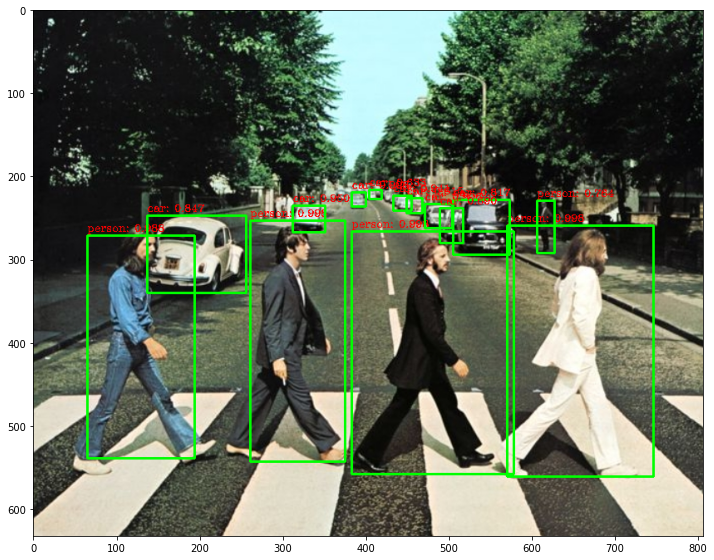

In [72]:
# 이미지 로드
default_dir = '/content/DLCV'
img = cv2.imread(os.path.join(default_dir, 'data/image/beatles01.jpg'))

# YOLO 모델 로드
CUR_DIR = '/content/DLCV/Detection/yolo'
weights_path = os.path.join(CUR_DIR, 'pretrained/yolov3.weights')
config_path = os.path.join(CUR_DIR, 'pretrained/yolov3.cfg')

cv_net_yolo = cv2.dnn.readNetFromDarknet(config_path, weights_path)

# YOLO로 Object Detection 수행
conf_threshold = 0.5
nms_threshold = 0.4

res_img = get_detected_img(cv_net_yolo, img, conf_threshold, nms_threshold)

# Detection 수행한 이미지 RGB로 변경
img_rgb = cv2.cvtColor(res_img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 12))
plt.imshow(img_rgb)
plt.show()

# OpenCV기반 YOLO-V3로 Video Object Detection 수행

In [83]:
# Video Object Detection 함수화

def do_detected_video(cv_net, input_path, output_path,
                      conf_threshold, nms_threshold, is_print=True):
  cap = cv2.VideoCapture(input_path) # Video Capture 정의
  codec = cv2.VideoWriter_fourcc(*'XVID') # 코덱
  vid_size = (round(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),
              round(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))) # 프레임 사이즈
  vid_fps = cap.get(cv2.CAP_PROP_FPS) # Video의 FPS 값
  frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Video 프레임 수
  # VideoWriter 정의 - 아웃풋경로, 코덱, fps, size 할당
  vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
  print("총 프레임 개수:", frame_cnt)

  green, red = (0, 255, 0), (0, 0, 255)

  while True:
    hasFrame, imgFrame = cap.read()
    if not hasFrame:
      print("더 이상 처리할 프레임이 없습니다!")
      break

    res_frame = get_detected_img(cv_net, imgFrame,
                                 conf_threshold, nms_threshold,
                                 use_copied_img=True,
                                 is_print=True)
    vid_writer.write(res_frame)

  vid_writer.release()
  cap.release()

In [84]:
default_dir = '/content/DLCV'

do_detected_video(cv_net_yolo, os.path.join(default_dir, 'data/video/John_Wick_small.mp4'), 
                  os.path.join(default_dir, 'data/output/John_Wick_small_yolo01.avi'), conf_threshold,
                  nms_threshold, True)

총 프레임 개수: 58
Detection 수행 시간: 1.911543607711792 초
Detection 수행 시간: 1.8931183815002441 초
Detection 수행 시간: 1.904860258102417 초
Detection 수행 시간: 1.9104013442993164 초
Detection 수행 시간: 1.8849611282348633 초
Detection 수행 시간: 1.901439905166626 초
Detection 수행 시간: 1.8841521739959717 초
Detection 수행 시간: 1.9058022499084473 초
Detection 수행 시간: 1.8946208953857422 초
Detection 수행 시간: 1.8988444805145264 초
Detection 수행 시간: 1.8911771774291992 초
Detection 수행 시간: 1.8862640857696533 초
Detection 수행 시간: 1.8880894184112549 초
Detection 수행 시간: 1.8720872402191162 초
Detection 수행 시간: 1.9032385349273682 초
Detection 수행 시간: 1.8934369087219238 초
Detection 수행 시간: 1.9009582996368408 초
Detection 수행 시간: 1.899247169494629 초
Detection 수행 시간: 1.8910257816314697 초
Detection 수행 시간: 1.9103002548217773 초
Detection 수행 시간: 1.8914027214050293 초
Detection 수행 시간: 1.8863306045532227 초
Detection 수행 시간: 1.8868141174316406 초
Detection 수행 시간: 1.888852834701538 초
Detection 수행 시간: 1.8913984298706055 초
Detection 수행 시간: 1.899890422821045 초
Detec

In [85]:
import os, sys 
from google.colab import drive 

drive.mount('/content/gdrive')
!cp /content/DLCV/data/output/John_Wick_small_yolo01.avi '/content/gdrive/My Drive/John_Wick_small_yolo01.avi'

Mounted at /content/gdrive


In [86]:
# Tiny YOLO 모델 wget으로 다운받고 위에랑 똑같이 적용
%cd /content/DLCV/Detection/yolo/pretrained
!echo "##### downloading pretrained yolo/tiny-yolo weight file and config file"
!wget https://pjreddie.com/media/files/yolov3.weights
!wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true -O ./yolov3.cfg

!wget https://pjreddie.com/media/files/yolov3-tiny.weights
!wget wget https://github.com/pjreddie/darknet/blob/master/cfg/yolov3-tiny.cfg?raw=true -O ./yolov3-tiny.cfg

!echo "##### check out pretrained yolo files"
!ls /content/DLCV/Detection/yolo/pretrained

/content/DLCV/Detection/yolo/pretrained
##### downloading pretrained yolo/tiny-yolo weight file and config file
--2021-04-15 08:29:41--  https://pjreddie.com/media/files/yolov3.weights
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 248007048 (237M) [application/octet-stream]
Saving to: ‘yolov3.weights.1’

yolov3.weights.1    100%[===================>] 236.52M  41.1MB/s    in 6.1s    

2021-04-15 08:29:47 (39.0 MB/s) - ‘yolov3.weights.1’ saved [248007048/248007048]

--2021-04-15 08:29:47--  https://github.com/pjreddie/darknet/blob/master/cfg/yolov3.cfg?raw=true
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/pjreddie/darknet/raw/master/cfg/yolov3.cfg [following]
--2021-04-15 08:29:47--  https://github.c